# Imports 🎈

Добавление всех необходимых библиотек и формирование requerments.txt

In [ ]:
import pip
pip.main(['install', 'imgaug'])

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
import imgaug.augmenters as iaa
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import cv2 

from typing import Tuple, List
import matplotlib.patches as patches
from tqdm import tqdm

%pylab inline
plt.style.use("bmh")
plt.rc('font', size=14)

Populating the interactive namespace from numpy and matplotlib


# Data
* Чтение данных [по мусорным бакам]
* Первый взгляд
* Формирование датасета

In [2]:
base_path = "data/trash/"
cams = os.listdir(base_path)

In [3]:
temp_img = os.listdir(base_path + cams[0])[0]
temp_label = os.listdir(base_path + cams[0])[1]
temp_img = Image.open(base_path + cams[0] + '/' + temp_img)
with open(base_path + cams[0] + '/' + temp_label) as f:
    label = f.readlines()
temp_img = numpy.asarray(temp_img)

In [4]:
def convert_label(label_row:str, img_shape:tuple) -> Tuple[int, list]:
    """Convert row to label and coordinates of trash cans"""
    
    data = label_row.split()
    label = data.pop(0)
    data = [float(x) for x in data]
    x, y, w, h = int(data[0] * img_shape[1]), int(data[1] * img_shape[0]), int(data[2] * img_shape[1]), int(data[3] * img_shape[0]) 
    cropping = int(x - w/2), int(x + w/2), int(y - h/2), int(y + h/2)
    return int(label), cropping

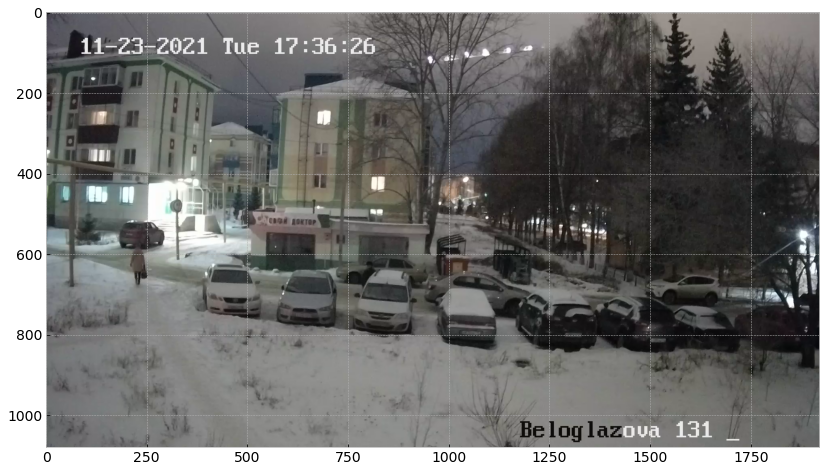

In [5]:
plt.figure(figsize=(15,8))
plt.imshow(temp_img)
plt.show()

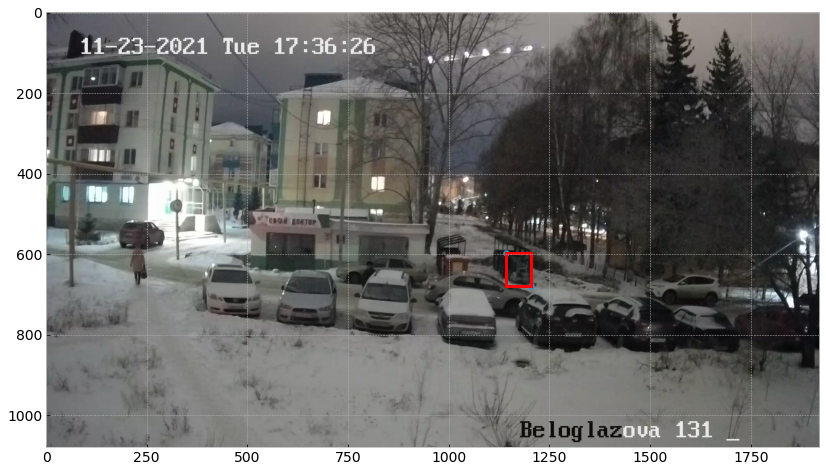

In [6]:
p, c = convert_label(label[1], temp_img.shape)
fig, ax = plt.subplots(1, figsize=(15,8))
ax.imshow(temp_img)
rect = patches.Rectangle([c[0], c[2]], c[1] - c[0], c[3] - c[2], linewidth=3, edgecolor='r', facecolor='none')
ax.scatter(c[:2], c[2:])
ax.add_patch(rect)
plt.show()

In [7]:
def samples_proccesor(path:str, img_name:str, label_name:str) -> Tuple[List[dict], list]:
    """Get samples from one image and list of labels"""
    
    img = numpy.asarray(Image.open(path + img_name))
    with open(path + label_name) as f:
        label = f.readlines()
    
    samples = []
    pd_dict = []
    for row in label:
        l, crop = convert_label(row, img.shape)
        samples.append(cv2.resize(img[crop[2]:crop[3], crop[0]:crop[1]], dsize=(192, 192), interpolation=cv2.INTER_CUBIC))
        pd_dict.append({
            "label": l, "path": path, "label_name": label_name, "img_name": img_name
        })
    return pd_dict, samples

In [8]:
p, s = samples_proccesor(base_path + cams[1] + "/", "23-11-2021_06-11-12_PM.png", "23-11-2021_06-11-12_PM.txt")

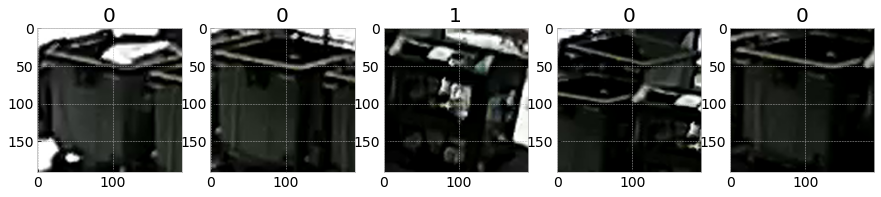

In [9]:
fig, ax = plt.subplots(1, len(s), figsize=(15, 8))
for i in range(len(s)):
    ax[i].imshow(s[i])
    ax[i].set_title(p[i]["label"])
plt.show()

In [10]:
def load_all_dirs(path:str) -> Tuple[pd.DataFrame, list]:
    cams = os.listdir(path)
    
    data = pd.DataFrame(columns=["label", "path", "label_name", "img_name"])
    all_samples = []
    for cam in tqdm(cams):
        temp_path = path + cam + "/"
        files = os.listdir(temp_path)
        i = 0
        while i < len(files):
            img_name = files[i]
            label = files[i + 1]
            p, s = samples_proccesor(temp_path, img_name, label)
            data = data.append(p, ignore_index=True)
            all_samples.extend(s)
            i += 2
    return data, all_samples       

In [11]:
table, samples = load_all_dirs(base_path)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:23<00:00,  1.99s/it]


start idx:44


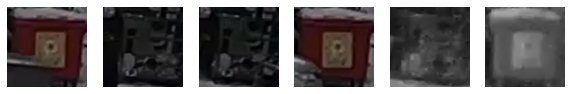

In [12]:
a = input("start idx:")
fig, ax = plt.subplots(1, 6, figsize=(10, 6))
for idx, i in enumerate(range(int(a), int(a) + 6)):
    ax[idx].imshow(samples[i])
    ax[idx].axis("off")
plt.show()

## Балансировка классов
* Соотношение данных
* Балансировка/аугментация

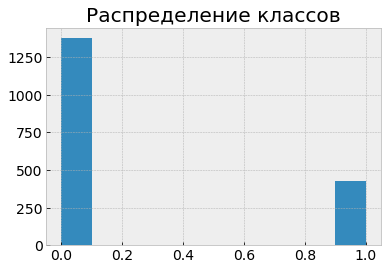

In [13]:
fig, ax = plt.subplots(1)
s=table["label"].hist(ax=ax)
ax.set_title("Распределение классов")
plt.show()
del s

In [14]:
table["label"] = table["label"].astype(int)
weights = compute_class_weight('balanced', classes=table["label"].unique(), y=table["label"].values)
weights = {0: weights[0], 1: weights[1]}
print("Веса сбалансированных классов:", weights)

Веса сбалансированных классов: {0: 0.6544331395348837, 1: 2.1188235294117646}


In [15]:
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc', factor=0.2, patience=20, verbose=0,
    mode='min', cooldown=30)

In [16]:
x_train = np.asarray(samples)
y_train = np.eye(2)[table["label"].values]
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

In [17]:
seq_aug = iaa.Sequential([
    iaa.SomeOf((0, 3), [
    iaa.GaussianBlur(sigma=(0, .5)),
    iaa.pillike.Autocontrast(),
    iaa.MotionBlur(angle=180)
    ])
])

In [18]:
x_train_aug = X_train.copy()
y_trian_aug = y_train.copy()

In [19]:
x_train_aug.shape, x_train_aug.shape

((1620, 192, 192, 3), (1620, 192, 192, 3))

In [20]:
for step in tqdm(range(5)):
    x_train_aug = np.vstack([x_train_aug, seq_aug(images=X_train)])
    y_trian_aug = np.vstack([y_trian_aug, y_train])

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.25s/it]


In [21]:
x_train_aug.shape, y_trian_aug.shape

((9720, 192, 192, 3), (9720, 2))

In [22]:
print("Чистый датасет:", X_train.size // 9863168, "Mb\nПосле аугментации:", x_train_aug.size // 9863168, "Mb")

Чистый датасет: 18 Mb
После аугментации: 108 Mb


# Модель
* MobileNet - эффективно обучается **без аугментации**

In [26]:
tf.keras.backend.clear_session()
mobile_net = tf.keras.applications.MobileNet(
    input_shape=(192,192,3),
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=False,
    weights="imagenet",
    classifier_activation="softmax"
)

x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(mobile_net.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(100, activation="sigmoid")(x)
x = tf.keras.layers.Dense(16, activation="sigmoid")(x)
x = tf.keras.layers.Dense(2, activation="softmax")(x)

rubbish_model = tf.keras.models.Model(mobile_net.input, x)
rubbish_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]
)

In [30]:
%%time
history = rubbish_model.fit(
    X_train, y_train, batch_size=64,
    epochs=400, class_weight=weights,
    validation_data=(X_test, y_test),
    validation_batch_size=64,
    callbacks=[plateau], shuffle=True,
    verbose=0
)
rubbish_model.save_weights("rubbish_net_long_train")

Wall time: 58min 49s


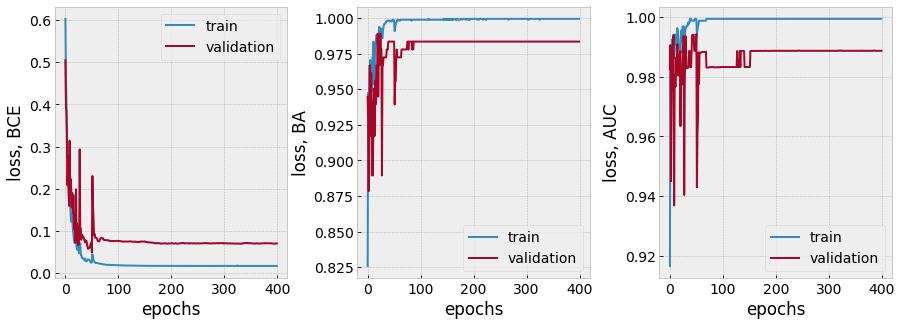

In [31]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history.history["loss"], label="train")
ax[0].plot(history.history["val_loss"], label="validation")
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss, BCE")
ax[0].legend(loc="best")

ax[1].plot(history.history["binary_accuracy"], label="train")
ax[1].plot(history.history["val_binary_accuracy"], label="validation")
ax[1].set_xlabel("epochs")
ax[1].set_ylabel("loss, BA")
ax[1].legend(loc="best")

ax[2].plot(history.history["auc"], label="train")
ax[2].plot(history.history["val_auc"], label="validation")
ax[2].set_xlabel("epochs")
ax[2].set_ylabel("loss, AUC")
ax[2].legend(loc="best")
plt.subplots_adjust(wspace = .3)
plt.show()

In [33]:
%%time
a = rubbish_model.evaluate(X_test, y_test, verbose=0)
print("Метрики на валидации\n{:20s}:{:.4f}\n{:20s}:{:.4f}\n{:20s}:{:.4f}\n\nВремя для {:d} картинок".format(
    "loss", a[0], "BA", a[1], "AUC", a[2], len(y_test))
)

Метрики на валидации
loss                :0.0702
BA                  :0.9834
AUC                 :0.9887

Время для 181 картинок
Wall time: 895 ms


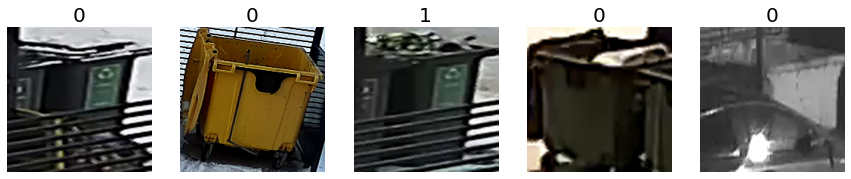

In [36]:
fig, ax = plt.subplots(1, 5, figsize=(15, 8))
for i in range(5):
    ax[i].imshow(X_test[i])
    ax[i].set_title(str(np.argmax(y_test[i])))
    ax[i].axis('off')
plt.show()

# Детектор
* Глубокая сеть с 2 головами для класса и bbox'а
* Необходимо 1 раз обучить и применять при изменении положения / добавлении камер для выделения новых мусорных баков

In [16]:
def detector_samples_proccesor(path:str, img_name:str, label_name:str) -> Tuple[List[dict], list]:
    """Get samples from one image and list of labels"""
    
    img = numpy.asarray(Image.open(path + img_name))
    with open(path + label_name) as f:
        label = f.readlines()
        
    data = label_row.split()
    label = data.pop(0)
    data = [float(x) for x in data]
    pd_dict = []
    for row in label:
        l, crop = convert_label(row, img.shape)
        samples.append(cv2.resize(img[crop[2]:crop[3], crop[0]:crop[1]], dsize=(192, 192), interpolation=cv2.INTER_CUBIC))
        pd_dict.append({
            "label": l, "path": path, "label_name": label_name, "img_name": img_name, ""
        })
    return pd_dict, cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

,label,path,label_name,img_name
0,0,data/trash/0/,23-11-2021_02-36-28_PM.txt,23-11-2021_02-36-28_PM.png
1,0,data/trash/0/,23-11-2021_02-36-28_PM.txt,23-11-2021_02-36-28_PM.png
2,0,data/trash/0/,23-11-2021_03-48-02_PM.txt,23-11-2021_03-48-02_PM.png
3,0,data/trash/0/,23-11-2021_03-48-02_PM.txt,23-11-2021_03-48-02_PM.png
4,0,data/trash/0/,23-11-2021_07-22-30_PM.txt,23-11-2021_07-22-30_PM.png
...,...,...,...,...
1796,0,data/trash/7/,26-11-2021_09-51-12_AM.txt,26-11-2021_09-51-12_AM.png
1797,0,data/trash/7/,26-11-2021_10-45-28_AM.txt,26-11-2021_10-45-28_AM.png
1798,0,data/trash/7/,26-11-2021_10-45-28_AM.txt,26-11-2021_10-45-28_AM.png
1799,0,data/trash/7/,26-11-2021_11-14-04_AM.txt,26-11-2021_11-14-04_AM.png


In [41]:
tf.keras.backend.clear_session()
mobile_net = tf.keras.applications.MobileNet(
    input_shape=(224,224,3),
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=False,
    weights="imagenet",
    classifier_activation="softmax"
)

flatten = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(mobile_net.output)
flatten = tf.keras.layers.Flatten()(flatten)
softmaxHead = tf.keras.layers.Dense(100, activation="sigmoid")(flatten)
softmaxHead = tf.keras.layers.Dropout(rate=0.3)(softmaxHead)
softmaxHead = tf.keras.layers.Dense(16, activation="sigmoid")(softmaxHead)
softmaxHead = tf.keras.layers.Dropout(rate=0.3)(softmaxHead)
softmaxHead = tf.keras.layers.Dense(2, activation="softmax", name="class_label")(softmaxHead)

bboxHead = tf.keras.layers.Dense(128, activation="relu")(flatten)
bboxHead = tf.keras.layers.Dense(64, activation="relu")(bboxHead)
bboxHead = tf.keras.layers.Dense(32, activation="relu")(bboxHead)
bboxHead = tf.keras.layers.Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

detector_model = tf.keras.models.Model(mobile_net.input, (softmaxHead, bboxHead))

losses = {
    "class_label": "binary_crossentropy",
    "bounding_box": "mean_squared_error",
}

loss_weights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}

detector_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=losses,
    loss_weights=loss_weights,
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]
)

In [60]:
table

,label,path,label_name,img_name,crop
0,0,data/trash/0/,23-11-2021_02-36-28_PM.txt,23-11-2021_02-36-28_PM.png,NaN
1,0,data/trash/0/,23-11-2021_02-36-28_PM.txt,23-11-2021_02-36-28_PM.png,NaN
2,0,data/trash/0/,23-11-2021_03-48-02_PM.txt,23-11-2021_03-48-02_PM.png,NaN
3,0,data/trash/0/,23-11-2021_03-48-02_PM.txt,23-11-2021_03-48-02_PM.png,NaN
4,0,data/trash/0/,23-11-2021_07-22-30_PM.txt,23-11-2021_07-22-30_PM.png,NaN
...,...,...,...,...,...
1796,0,data/trash/7/,26-11-2021_09-51-12_AM.txt,26-11-2021_09-51-12_AM.png,NaN
1797,0,data/trash/7/,26-11-2021_10-45-28_AM.txt,26-11-2021_10-45-28_AM.png,NaN
1798,0,data/trash/7/,26-11-2021_10-45-28_AM.txt,26-11-2021_10-45-28_AM.png,NaN
1799,0,data/trash/7/,26-11-2021_11-14-04_AM.txt,26-11-2021_11-14-04_AM.png,NaN
